# Genetic V2+3

Combinação das versões 2 e 3


### Versão 2:
T_min : quantidade de waypoints minima (3) 
T_max : (10)

primeiro decide o tamanho, depois preenche o gene


Seleciona aleatorio
 a mutação pode diminuir o tamanho do individuo
inserção aleatoria, aumentando o tamanho do cara

3 mutações:
33% de chance pra cada uma
- remove gene
verifica se estoura o limite T min

- insere gene
verifica se estoura o limite T max

- mutação creep


### Versão 3:
Alocação de Risco (relaxada)
- Inflar o tamanho das áreas em x% e considerar esse novo tamanho para calcular o fitness

## Versão 2 DevLog

#### INDIVÍDUO
- intervalo do parâmetro `a` passou de [0, 2] para [-2, 2]
- adicionados parâmetros T_min e T_max como parte da inicialização de Subject
- removido parâmetro T da inicialização do Subject
- adicionadas funções de mutação: creep, inserir, remover

#### ALGORITMO GENÉTICO
- A partir dessa versão o T passou a ser otimizado pelo AG.
- Dado os resultados do TESTE1, observei a necessidade de incluir o T como parâmetro para o fitness. A função de fitness passou a ser a seguinte:

$$fitness = C1*fDestino + C2*fConsumo + C3*fCurva + C4*fObstaculo + C5*fT$$

, onde fT é o tamanho do T.
- incluído custo de T como parâmetro de inicialização, C_t

#### GERAL
- aplicadas algumas otimizações nos loops "for"
- generalizada a função de plotar estatísticas no gráfico
- aumentada a visualização para diversas estatísticas de T (menor T, maior T, T médio, T do melhor)

##  Versão 3 DevLog

#### MAPA
- **Nova função adicionada para expandir a área em x%** (Necessário revisitar os cálculos pra ver se está tudo ok)

#### INDIVÍDUO
- Agora o indivíduo possui um stacktrace da função fitness, onde dá para saber de onde vem cada valor, facilitando o debug (retirar essa opção na versão final, para deixar otimizado)


#### ALGORITMO GENÉTICO
- Adicionado funcionalidade de debug, para visualizar melhor de onde vem cada valor do fitness
- Corrigido um erro onde na função fitness de obstáculo, estava considerando o segmento x\[T\] - x\[0\]
- Parametrizado a quantidade de indivíduos que disputam o torneio (k_tournament)



In [1]:
import collections
import random
import time
import copy

from math import cos, sin, sqrt, ceil

from itertools import tee
from utils import pairwise, point_in_polygon, segment_in_polygon

In [2]:
Gene           = collections.namedtuple('Gene', 'a e')
GeneDecoded    = collections.namedtuple('GeneDecoded', 'x y v al')
CartesianPoint = collections.namedtuple('CartesianPoint', 'x y')

In [3]:
class Mapa():
    def __init__(self, origin, destination, areas_n, inflation_rate=0.1):
        self.origin = origin           # CartesianPoint : Define o ponto de partida da rota
        self.destination = destination # CartesianPoint : Define o ponto de destino da rota
        #self.areas_n = areas_n        # [area, ...]
                                       # area = [CartesianPoint(),...]      
        self.areas_n_inf = [ self._inflate_area(area, inflation_rate=inflation_rate) for area in areas_n ]
        
        
    def _inflate_area(self, area, inflation_rate=0):
        # Infla uma área retangular em uma porcentagem do tamanho, alterando os valores em x% de cada vértice
        
        x = area[2].x - area[0].x
        y = area[1].y - area[3].y
        
        inc = (inflation_rate)
        dec = -(inflation_rate)
        
        new_area = [
            CartesianPoint(area[0].x + dec * x, area[0].y + dec * y), # left,  bottom
            CartesianPoint(area[1].x + dec * x, area[1].y + inc * y), # left,  top
            CartesianPoint(area[2].x + inc * x, area[2].y + inc * y), # right, top
            CartesianPoint(area[3].x + inc * x, area[3].y + dec * y)  # right, bottom
        ]
        new_area.append(new_area[0]) # Repetir primeiro ponto, para o ignore do shape na hora de plotar
        
        return new_area

In [4]:
class Subject():
    
    # codificação - u
    # dna = [Gene, ...]
    #     Gene = [a, e]
    #         a = float: aceleração
    #         e = float: variação angular


    # decodificação - x
    # dna_decoded = [GeneDecoded, ...]
    #     GeneDecoded = (x, y, v, al)
    #         x  = : Posição do VANT no eixo x (aka px)
    #         y  = : Posição do VANT no eixo y (aka py)
    #         v  = : Velocidade do VANT na horizontal
    #         al = : ângulo (direção) do VANT na horizontal
    
    def __init__(
        self,
        px0=10.,
        py0=10.,
        v0=0,
        al0=0,
        v_min=11.1,
        v_max=30.5,
        e_min=-3,
        e_max=3,
        a_min=-2.0,
        a_max=2.0,
        T_min=1,
        T_max=7,
        delta_T=1,
        m=743.0,
        mutation_prob=0.7,
        spawn_mode='random',
        **kwargs
    ):
        # VANT
        # px0   int : Posição inicial no eixo x (m)
        # py0   int : Posição inicial no eixo y (m)
        # v0    int : Velocidade Inicial (m/s)
        # al0   int : Ângulo inicial (graus)
        self.gene_decoded_0 = GeneDecoded(px0, py0, v0, al0) # GeneDecoded : objeto contendo o gene decodificado de posição 0
        self.v_min = v_min # float : Velocidade máxima (m/s)
        self.v_max = v_max # float : Velocidade mínima (m/s)
        self.e_min = e_min # int   : Velocidade angular mínima (graus/s)
        self.e_max = e_max # int   : Velocidade angular máxima (graus/s)
        self.a_min = a_min # float : Aceleração mínima (m/s**2)
        self.a_max = a_max # float : Aceleração máxima (m/s**2)
        
        # TODO9:implementar os initialize
        
        # Modelo
        self.T_min   = T_min   # int : Valor mínimo para o horizonte de planejamento
        self.T_max   = T_max   # int : Valor máximo para o horizonte de planejamento
        self.T       = random.randint(T_min, T_max) # int : Horizonte de planejamento (quantidade de waypoints)
        self.delta_T = delta_T # int : Discretização do tempo (s) Tempo que leva de um waypoint até o outro
        self.m       = m       # float : Massa do VANT (!=0) (gramas)
    
        # Parametros do indivíduo
        self.mutation_prob = mutation_prob # float : Probabilidade de ocorrer uma mutação no dna (%)
        self.fitness       = None          # float : Fitness do indivíduo
        self.dna           = None          # list  : Conjunto de genes formando o DNA ([Gene, ...])
        self.dna_decoded   = None          # list  : DNA decodificado ([GeneDecoded, ...])
        self.spawn_mode    = spawn_mode    # str   : Tipo de incialização do DNA {'random'}
        
        self.spawn(mode=spawn_mode)
        
    
    def set_fitness(self, fitness, fitness_trace):
        self.fitness = fitness
        self.fitness_trace = fitness_trace
    
    
    # ---
    
    def spawn(self, mode):
        self.dna = [self._build_gene(mode) for _ in range(self.T) ]
        
    def _build_gene(self, mode):
        # Inicialização aleatória gera valores com distribuição uniforme
        if mode == 'random':
            a = random.uniform(self.a_min, self.a_max)
            e = random.uniform(self.e_min, self.e_max)
            
        return Gene(a, e)
    
    # ---
    
    def decode(self):
        #self.dna_decoded = [self._decode_gene() for i in range(len(self.dna))]
        self.dna_decoded = self._decode_gene() # TODO: Organizar, voltar como era a linha de cima. Fazer função abaixo só computar o gene
        
    def _decode_gene(self):
        dna = self.dna
        
        # parametros
        delta_T = self.delta_T
        m = self.m
        
        dna_decoded = []
        dna_decoded.append(self.gene_decoded_0)
        
        for i in range(0, len(dna)):
            # dna
            a  = dna[i].a
            e  = dna[i].e
            
            # dna decodificado
            px = dna_decoded[i].x
            py = dna_decoded[i].y
            v  = dna_decoded[i].v
            al = dna_decoded[i].al
            
            F = self.__F(v)
        
            # Equações descritas em (Arantes 2016)
            _px = px + ( v * cos(al) * delta_T ) + ( a * cos(al) * ((delta_T**2)/2) ) 
            _py = py + ( v * sin(al) * delta_T ) + ( a * sin(al) * ((delta_T**2)/2) ) 
            _v  = v  + ( a * delta_T ) - ( (F/m) * delta_T )
            _al = al + ( e * delta_T )

            dna_decoded.append(GeneDecoded(_px, _py, _v, _al))

        return dna_decoded
    
    
    def __F(self, v):
        # Equação do Arrasto
        # Disponível em https://pt.wikipedia.org/wiki/Equa%C3%A7%C3%A3o_do_arrasto
        # Versão utilizada ((Arantes, 2016) equação 3.5)
        
        Cd  = 0.8     # float : Coeficiente de arrasto, específico para cada aeronave
                      #         (considerado Angled Cube) obtido de https://pt.wikipedia.org/wiki/Coeficiente_de_resist%C3%AAncia_aerodin%C3%A2mica
        rho = 1.225   # float : Massa específica do fuído (aka densidade) (k/m**3)
                      #         (a 15 graus Celsius) Valor de rho obtido de https://pt.m.wikipedia.org/wiki/Densidade_do_ar
        A = 1.0       # float : Área de referência # TODO: o que é isso?
        # v = v       # float : Velocidade do Vant no instante t (fornecido como parâmetro da função)
        
        F = 0.5 * Cd * rho * A * (v**2)
        
        return F
        
    
    # ---
    
    def crossover(self, parent2):
        dna = random.choice([self._OX, self._BLX_Alpha])(self.dna, parent2.dna)
        dna = self._complete(dna, self.dna, parent2.dna)
        child = self.generate(dna)
        return child
    
    
    def _complete(self, dna, dna1, dna2):
        # Adiciona os genes restantes da diferença de tamanho entre os dois DNAs
               
        if len(dna1) > len(dna2):
            bigger  = dna1
            smaller = dna2
        else:
            bigger  = dna2
            smaller = dna1
    
        for i in range(len(smaller)-1, len(bigger)-1):
            if random.random() < 0.5:
                dna.append(bigger[i])
                
        return dna
        
    
    def _OX(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            dna.append(random.choice([gene1, gene2]))
        return dna
        
        
    def _BLX_Alpha(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            a = self.__BLX_ALpha_select_gene(gene1.a, gene2.a)
            e = self.__BLX_ALpha_select_gene(gene1.e, gene2.e)
            a = min(a, self.a_max)
            a = max(a, self.a_min)
            e = min(e, self.e_max)
            e = max(e, self.e_min)
            
            gene = Gene(a, e)
            dna.append(gene)
            
        return dna
    
    
    def __BLX_ALpha_select_gene(self, x, y):
        # x - Gene : gene do pai 1
        # y - Gene : gene do pai 2
        alpha = random.uniform(0,1)
        d = abs(x-y)
        u = random.uniform(min(x,y)-alpha*d, max(x,y)+alpha*d)
        return u
    
    
    def generate(self, dna):
        # Cria um filho com os mesmos parametros do pai, mas com um dna fornecido
        child = copy.deepcopy(self)
        child.dna = dna
        child.decode()
        return child
    
        
    # ---
    
    def mutation(self, mutation_prob=None):
        mutation_prob = self.mutation_prob if not mutation_prob else mutation_prob # 0.7
        
        # Tem uma probabilidade mutation_prob de mutar o gene ou não
        if random.random() < mutation_prob:
            # Seleciona aleatoriamente uma das formas de mutação
            new_dna = random.choice([
                self._mutation_remove, 
                self._mutation_insert, 
                self._mutation_creep, 
                self._mutation_change
            ])(self.dna)
            
            if new_dna:
                self.dna = new_dna
                self.decode()
            
            return True
        return False
    
    def _mutation_change(self, dna):
        new_dna = []
        for gene in dna:
            if random.random() < 0.5:
                new_dna.append(self._build_gene('random'))
            else:
                new_dna.append(gene)
        
        return new_dna
    
    
    def _mutation_remove(self, dna):
        # Remove UM gene aleatório do DNA
        if len(dna) > self.T_min:
            i = random.randint(0, len(dna)-1)
            dna.pop(i)
            return dna
        return None
        
        
    def _mutation_insert(self, dna):
        # Insere UM gene aleatório no DNA em uma posição aleatória
        if len(dna) < self.T_max:
            i = random.randint(0, len(dna)-1)
            gene = self._build_gene()
            dna.insert(i, gene)
            return dna
        return None
    
    
    def _mutation_creep(self, dna):
        new_dna = []
        for gene in dna:
            a = self.__mute(gene.a, self.a_min, self.a_max)
            e = self.__mute(gene.e, self.e_min, self.e_max)

            # TODO2: otimizar
            new_gene = Gene(a, e)
            new_dna.append(new_gene)

        return new_dna
        
        
    def __mute(self, val, min_val, max_val):
        mutation_rate = random.uniform(0, max_val*0.5)
        s = random.choice([1, -1])
        val = val * (1 + (mutation_rate * s))

        # Checa se não estoura os limites
        val = max(val, min_val)
        val = min(val, max_val)

        return val
    
    
    # ---
    
    def get_route(self):
        return [ [gene.x, gene.y] for gene in self.dna_decoded ]
    


        

In [11]:
class Genetic():
    
    def __init__(
        self, 
        Specie, 
        mapa,
        taxa_cross=1.0,
        population_size=100,
        C_d=1000,
        C_obs=1000,
        C_con=10,
        C_cur=0,
        C_t=0,
        max_exec_time=5,
        min_precision=1.0,
        k_tournament=2,
        **kwargs
    ):
        # Modelo
        self.Specie = Specie # objeto : Definição da classe (não a instância)
        self.mapa   = mapa   # Mapa   : Mapa com as características da missão

        # Parâmetros
        self.taxa_cross      = taxa_cross      # float : Taxa de ocorrencia do crossover [0,1]
        self.population_size = population_size # int   : Quantidade máxima de indivíduos na população 
        self.C_d             = C_d             # int   : Custo associado ao fitness de destino
        self.C_obs           = C_obs           # int   : Custo associado ao fitness de obstáculos
        self.C_con           = C_con           # int   : Custo associado ao fitness de consumo de combustível
        self.C_cur           = C_cur           # int   : Custo associado ao fitness de curvatura da rota
        self.C_t             = C_t             # int   : Custo associado ao fitness do tamanho do DNA (T ou horizonte de planejamento)
        self.max_exec_time   = max_exec_time   # float : Tempo máximo de execução - Stop criteria (segundos)
        self.min_precision   = min_precision   # float : Precisão mínima de acerto ao destino (metros)
        self.k_tournament    = k_tournament    # int   : Quantidade de indivíduos disputando o torneio
        
        # Alguns dos valores do kwargs são passados para a instanciação dos indivíduos
        self.kwargs = kwargs
        
        # Inicialização
        self.population = None 
        self.fitnesses  = None
        self.best       = None
        self.ancestry   = []
        

        
    def run(self, max_exec_time=None, verbose=False, info=False, debug=False):
        self.max_exec_time = max_exec_time if max_exec_time else self.max_exec_time
        
        # Acompanhamento do tempo (critério de parada)
        self.start_time = time.time()
        
        # Genesis
        self.population = self._genesis(self.Specie, self.population_size)
        
        # Inicializar
        self._decode(self.population)
        
        # Avaliar
        self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
    
        # Escolher melhor de todos
        self.best = self.population[self.fitnesses.index(max(self.fitnesses))]
        
        
        self.trace = []
        
        while not self.stop_criteria():
            self.flag_newborn = self.population_size
            count_while = 0
            
            while not self.converge():
                self.flag_newborn = 0
                count_while += 1
                
                for i in range(ceil(self.taxa_cross * self.population_size)):
                    # Seleção por torneio
                    parent1, parent2 = self._tournament(self.population, k=self.k_tournament)
            
                    # Crossover
                    child = parent1.crossover(parent2)
                    
                    # Mutação
                    child.mutation()
                    
                    # Fitness
                    self._fitness(child, self.mapa)
                    
                    # Adicionar filho na população
                    self._insert(child, parent1, parent2)
                    
                    # Print
                    if verbose and self.flag_newbest:
                        print('  Novo melhor de todos! fit: {}'.format(self.best.fitness))
                    if debug:
                        print('\nparent1.dna', parent1.dna)
                        print('\nparent2.dna', parent2.dna)
                        print('\nchild.dna.mutation', child.dna)
                        
                        
                aux_T_dna = [len(subject.dna) for subject in self.population]
                self.trace.append({
                    'medium_fitness': sum(self.fitnesses)/self.population_size,
                    'best_fitness': self.best.fitness,
                    'newborns': self.flag_newborn,
                    'newbest': self.flag_newbest,
                    'T_medio': sum(aux_T_dna)/self.population_size,
                    'T_maior': max(aux_T_dna),
                    'T_menor': min(aux_T_dna),
                    'T_melhor': len(self.best.dna)
                })
                
                # Print
                if verbose:
                    print('Fim da geração. {} novos indivíduos'.format(self.flag_newborn))
                    print('Melhor de todos: {}'.format(self.best.fitness))
                    print('-'*20)
                        
                        
            # Reiniciar rotas
            self.population = []
            self.population = self._genesis(self.Specie, self.population_size-1)
            # Nunca matar o melhor de todos
            self.population.append(self.best)
            
            # Inicializar
            self._decode(self.population)
            
            # Avaliar
            self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
            
            # Print
            if verbose:
                print('Meteoro! Reiniciando rotas')
            if info:
                print('Meteoro! Melhor de todos:{} - count:{}'.format(self.best.fitness, count_while))
                
                
        return self.best
                      
    # ---
    
    def _insert(self, child, parent1, parent2):
        # Verifica se um indivíduo é digno de entrar na população e tomar o lugar de um de seus pais

        self.flag_newbest = False
        
        if child.fitness < parent1.fitness:
            self.__substitute(child, parent1)

        elif child.fitness < parent2.fitness:
            self.__substitute(child, parent2)

        if child.fitness < self.best.fitness:
            self.best = child
            self.ancestry.append(child)
            self.flag_newbest = True
    
    
    def __substitute(self, child, parent):
        i_parent = self.population.index(parent)

        self.population.remove(parent)
        self.population.append(child)

        self.fitnesses.pop(i_parent)
        self.fitnesses.append(child.fitness)
        self.flag_newborn += 1
    
    
    # ---
    
    def stop_criteria(self):
        # Para a execução depois de uma quantidade de segundos
        if (time.time() - self.start_time) >= self.max_exec_time:
            return True
        return False
    
    def converge(self):
        # Converge caso nenhum novo indivíduo seja adicinado
        if self.flag_newborn == 0:
            return True
        return False
                         
    # ---
    
    def _genesis(self, Specie, population_size):
        population = [Specie(**self.kwargs) for i in range(population_size)]
        return population 
    
    # ---
    
    def _decode(self, population):
        for subject in population:
            subject.decode()
        return True
    
    # ---
    
    def _fitness(self, subject, mapa):
        
        fit_d   = self.__fitness_destination(subject, mapa)
        fit_obs = self.__fitness_obstacles(subject, mapa)
        fit_con = self.__fitness_consumption(subject, mapa)
        fit_cur = self.__fitness_curves(subject, mapa)
        fit_t   = self.__fitness_t(subject, mapa)
        
        fitness_trace = [self.C_d   * fit_d,
                         self.C_obs * fit_obs,
                         self.C_con * fit_con,
                         self.C_cur * fit_cur,
                         self.C_t   * fit_t]
        
        fitness = sum(fitness_trace)
        
        subject.set_fitness(fitness, fitness_trace)
        
        return fitness
    
    def __fitness_destination(self, subject, mapa):
        # Prioriza rotas que acertem o destino
        
        A = subject.dna_decoded[-1] # Último waypoint da rota
        B = mapa.destination        # Waypoint de destino
        
        # Distância euclidiana entre o último ponto da rota e o ponto de destino
        d = sqrt( (B.x - A.x)**2 + (B.y - A.y)**2 )
        
        # Determina uma precisão mínima aceita
        if d < self.min_precision: # min_precision default = 1.0
            return 0
        return d

    
    def __fitness_obstacles(self, subject, mapa):
        # Prioriza rotas que não ultrapassem obstáculos
        count = 0
        
        for gene_decoded_t1, gene_decoded_t2  in pairwise(subject.dna_decoded):
            # Utiliza somente as áreas infladas para cálculo
            for area_n in mapa.areas_n_inf:
                wp1 = CartesianPoint(gene_decoded_t1.x, gene_decoded_t1.y)
                wp2 = CartesianPoint(gene_decoded_t2.x, gene_decoded_t2.y)
                
                # Calcula se algum waypoint está dentro de algum obstáculo
                if point_in_polygon(wp1, area_n):
                    count += 1
                    
                # Calcula se alguma conexão entre os waypoints intersecciona algum obstáculo
#                 if segment_in_polygon(wp1, wp2, area_n):
#                     count += 1
            
        return count
    
    
    def __fitness_consumption(self, subject, _):
        # Prioriza rotas com menor consumo de combustível (bateria)
        consumption = [gene.a**2 for gene in subject.dna]
        return sum(consumption)
    
        
    def __fitness_curves(self, subject, _):
        # Prioriza rotas que evitem fazer curvas desnecessárias
        curves = [abs(gene.e) for gene in subject.dna]
        return (1/subject.e_max) * sum(curves)
        
        
    def __fitness_t(self, subject, _):
        # Prioriza rotas com menor quantidade de waypoints
        return len(subject.dna)
    
        
    # ---
        
    def _tournament(self, population, k=2):
        parents = []
        for i in range(2):
            
            local_best = random.choice(population)
            for j in range(k-1):
                # Seleciona k individuos
                a = random.choice(population)
                if a.fitness > local_best.fitness:
                    local_best = a
                    
            parents.append(local_best)
            
        # Retorna o resultado de duas batalhas
        return parents[0], parents[1]
        
        

        
        
        

### Execution

In [6]:
from visualization import plot_map, plot_stats
# import genetic_v1 as genetic 
# Subject, Genetic, Mapa, Gene, GeneDecoded, CartesianPoint

Meteoro! Melhor de todos:6802.22756675463 - count:631
Meteoro! Melhor de todos:6802.22756675463 - count:67
Meteoro! Melhor de todos:171.06814543163821 - count:792
------------------------------
Gene(a=2.0, e=0.7984143672873762)
Gene(a=2.0, e=-0.06094565483944991)
Gene(a=2.0, e=-0.0022357104237570313)
Gene(a=0.15907488314284934, e=-0.5414171731823831)
Gene(a=0.5216909875506314, e=-0.6061330323807415)
Gene(a=2.0, e=-0.528210985734316)
Gene(a=0.8996378372575027, e=-0.6761858145883612)
------------------------------
GeneDecoded(x=10.0, y=10.0, v=0, al=0)
GeneDecoded(x=11.0, y=10.0, v=2.0, al=0.7984143672873762)
GeneDecoded(x=13.093529888942602, y=12.148751405841072, v=3.997362045760431, al=0.7374687124479263)
GeneDecoded(x=16.792442384756402, y=15.509059987611414, v=5.986824141818043, al=0.7352330020241693)
GeneDecoded(x=21.291707988560077, y=19.578132595325943, v=6.122261594248271, al=0.19381582884178616)
GeneDecoded(x=27.55530055226086, y=20.807548836120407, v=6.619233574202779, al=-0.41

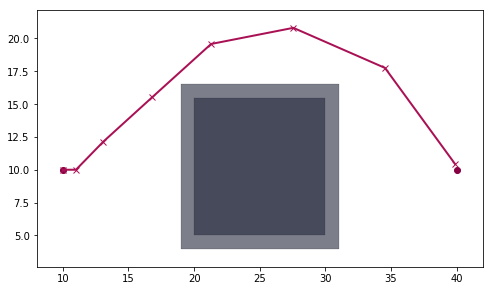

In [27]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (20.0, 5.0), # left, bottom
    (20.0, 15.5), # left, top
    (30.0, 15.5), # right, top
    (30.0, 5.0), # right, bottom
    (20.0, 5.0), # ignored
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]


mapa1 = Mapa(wp_ori, wp_des, [verts1])

ag = Genetic(Subject, mapa1,
        taxa_cross=1.0,
        population_size=80,
        C_d=1000,
        C_obs=100000,
        C_con=10,
        C_cur=0,
        C_t=1
)

best = ag.run(max_exec_time=60, info=True)
print('-'*30)
for dna in best.dna:
    print(dna)
print('-'*30)
for dna_decoded in best.dna_decoded:
    print(dna_decoded)
best = ag.best

plot_map(
    [verts1, mapa1.areas_n_inf[0]], 
    ['n', 'n'], 
    wp_ori, 
    wp_des, 
    best.get_route(),
    None
)
#plot_stats(ag.trace, normalize=True)
#plot_stats(ag.trace, normalize=False)

188.8665325449415


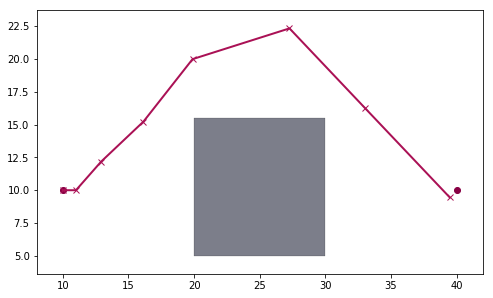

In [40]:
best = ag.ancestry[-2]
print(best.fitness)
plot_map(
    [verts1], 
    ['n'], 
    wp_ori, 
    wp_des, 
    best.get_route(),
    None
)

In [32]:
print('{} = {}'.format(best.fitness_trace, best.fitness))
# destino, obstaculo, consumo, curva, wp

[193.28896219980962, 0, 132.51673970788218, 0.0, 0] = 325.8057019076918


In [32]:
print('{} = {}'.format(best.fitness_trace, best.fitness))
# destino, obstaculo, consumo, curva, wp

[193.28896219980962, 0, 132.51673970788218, 0.0, 0] = 325.8057019076918


In [ ]:
# TODO1: printar o time da solução encontrada

In [7]:
mapa_file = [
{
	"id": 0,
	"name": "Mapa C2",
	"geo_home": [-47.932949, -22.002467, 0],
	"areas_bonificadoras":[],
	"areas_penalizadoras":[],
	"areas_nao_navegaveis":[
		{
			"id": "NN1",
			"name": "Campo atras dos containers",
			"geo_points":[
				[-47.932749, -22.002332, 7], 
				[-47.932794, -22.002177, 13], 
				[-47.932664, -22.002147, 13], 
				[-47.932612, -22.002306, 7]
    			]
    		},
		{
			"id": "NN2",
			"name": "Bloco de aula",
			"geo_points":[
				[-47.932099, -22.002278, 20],
				[-47.932063, -22.002396, 20],
				[-47.932772, -22.002582, 20],
				[-47.932811, -22.002465, 20]
			]
		}
    ]
}
]


Meteoro! Melhor de todos:44232.99090021093 - count:103
Meteoro! Melhor de todos:40975.766351019454 - count:99
Meteoro! Melhor de todos:40975.766351019454 - count:76
Meteoro! Melhor de todos:40975.766351019454 - count:82
Meteoro! Melhor de todos:40975.766351019454 - count:100
Meteoro! Melhor de todos:35150.07356547119 - count:114
Meteoro! Melhor de todos:35150.07356547119 - count:91
Meteoro! Melhor de todos:35150.07356547119 - count:111
Meteoro! Melhor de todos:35150.07356547119 - count:109
Meteoro! Melhor de todos:35150.07356547119 - count:87
Meteoro! Melhor de todos:35150.07356547119 - count:100
Meteoro! Melhor de todos:35150.07356547119 - count:110
Meteoro! Melhor de todos:35150.07356547119 - count:124
Meteoro! Melhor de todos:35150.07356547119 - count:118
Meteoro! Melhor de todos:35150.07356547119 - count:130
Meteoro! Melhor de todos:35150.07356547119 - count:112
Meteoro! Melhor de todos:35150.07356547119 - count:78
Meteoro! Melhor de todos:35150.07356547119 - count:98
Meteoro! Melh

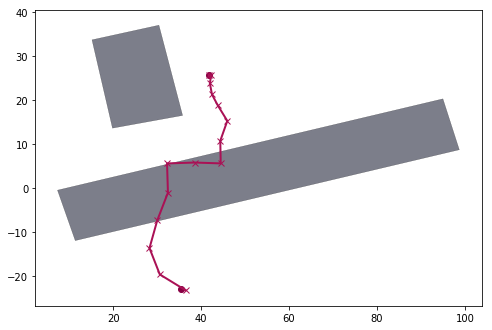

In [29]:
import argparse

from visualization import plot_map
from genetic_v2_3 import Subject, Genetic 
from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=0.1)



## EXECUÇÃO DO AG

ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=1000,
        C_con=1000,
        C_cur=1000,
        C_t=1000,
        max_exec_time=600,
        #Subject,
        T_min=10,
        T_max=50,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


plot_map(
    mapa.areas_n_inf, 
    ['n' for _ in range(len(mapa.areas_n_inf))], 
    cart_origin, 
    cart_destination, 
    best.get_route(),
    None
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)

In [31]:
import argparse

from visualization import plot_map
from genetic_v2_3 import Subject, Genetic 
from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=0.1)



## EXECUÇÃO DO AG

ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=2000,
        C_con=1000,
        C_cur=1000,
        C_t=500,
        max_exec_time=600,
        #Subject,
        T_min=10,
        T_max=50,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


plot_map(
    mapa.areas_n_inf, 
    ['n' for _ in range(len(mapa.areas_n_inf))], 
    cart_origin, 
    cart_destination, 
    best.get_route(),
    None
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)

Meteoro! Melhor de todos:31349.005787708888 - count:123
Meteoro! Melhor de todos:30683.165364989116 - count:136
Meteoro! Melhor de todos:30683.165364989116 - count:108
Meteoro! Melhor de todos:30683.165364989116 - count:89
Meteoro! Melhor de todos:30683.165364989116 - count:88
Meteoro! Melhor de todos:30683.165364989116 - count:73
Meteoro! Melhor de todos:30683.165364989116 - count:93
Meteoro! Melhor de todos:30683.165364989116 - count:84
Meteoro! Melhor de todos:30683.165364989116 - count:115


KeyboardInterrupt: 

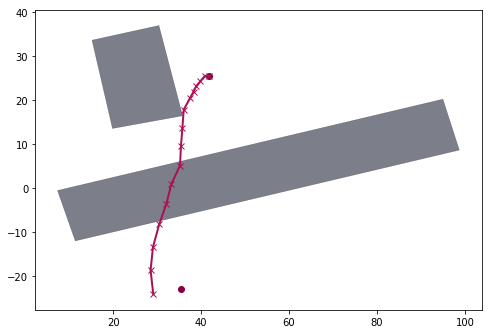

In [32]:
best = ag_teste.best

plot_map(
    mapa.areas_n_inf, 
    ['n' for _ in range(len(mapa.areas_n_inf))], 
    cart_origin, 
    cart_destination, 
    best.get_route(),
    None
)

In [27]:
# TODO1:Ver o bug de conversão geo->cart

In [22]:
best.fitness_trace
# Dist obs consumo, curva, t

[1588.241812695795, 3000, 0.0, 0.0, 0]